# Install Packages

In [1]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install xgboost
!pip install scikit-learn

# Import Libraries

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

# Data Pre-processing

In [3]:
file_path_temperature = 'sensor_data_vendor_data.csv'
df = pd.read_csv(file_path_temperature)

df_temperature = df[['Time','Temperature']].copy()

df_temperature['Time'] = pd.to_datetime(df_temperature['Time'])

df_temperature.rename(columns={'Time': 'dateTime'}, inplace=True)

df_temperature.set_index('dateTime', inplace=True)
df_temperature.index = pd.to_datetime(df_temperature.index)

df_temperature.dropna(inplace=True)

df_temperature['Temperature'] = df_temperature['Temperature'].str.extract('([0-9.]+)').astype(float)

print(df_temperature)
print(df_temperature.shape)

                     Temperature
dateTime                        
2023-12-31 20:00:00         24.0
2023-12-31 14:00:00         24.1
2023-12-31 08:00:00         23.9
2023-12-31 02:00:00         23.7
2023-12-30 20:00:00         23.5
...                          ...
2023-09-10 14:00:00         25.2
2023-09-10 08:00:00         24.8
2023-09-10 02:00:00         24.3
2023-09-09 20:00:00         23.9
2023-09-09 14:00:00         23.1

[454 rows x 1 columns]
(454, 1)


# Remove Outlier

In [4]:
mean_temp = df_temperature['Temperature'].mean()
std_temp = df_temperature['Temperature'].std()

df_temperature['Z_score'] = (df_temperature['Temperature'] - mean_temp) / std_temp

# Remove the data points with Z-scores beyond +/- 3 standard deviations
df_temperature = df_temperature[df_temperature['Z_score'].abs() <= 3]

df_temperature.drop('Z_score', axis=1, inplace=True)

df_temperature.shape

(451, 1)

# Visualise Dataset

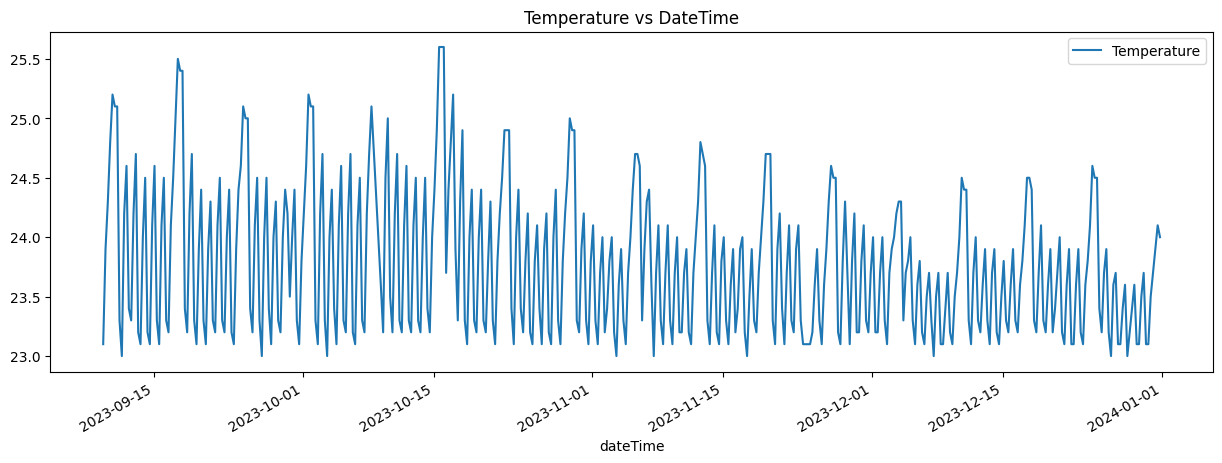

In [5]:
df_temperature.plot(figsize=(15, 5),
                    color=color_pal[0],
                    title='Temperature vs DateTime',
                    linestyle='-')  # Optional, '-' is the default for line plots
plt.show()


# Train / Test Split

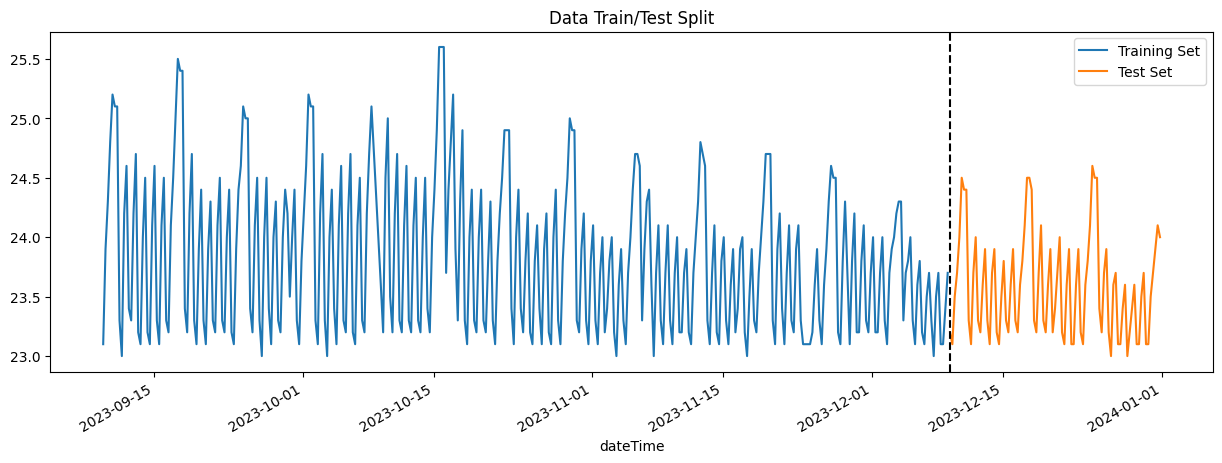

In [6]:
df_temperature = df_temperature.sort_index()

split_point = int(len(df_temperature) * 0.8)

train = df_temperature.iloc[:split_point]
test = df_temperature.iloc[split_point:]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')

split_date = df_temperature.index[split_point]
ax.axvline(split_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Feature Creation

In [7]:
# Create time series features based on time series index.
def create_features(df_temperature):
    df_temperature = df_temperature.copy()
    df_temperature['hour'] = df_temperature.index.hour
    df_temperature['dayofweek'] = df_temperature.index.dayofweek
    df_temperature['quarter'] = df_temperature.index.quarter
    df_temperature['month'] = df_temperature.index.month
    df_temperature['year'] = df_temperature.index.year
    df_temperature['dayofyear'] = df_temperature.index.dayofyear
    df_temperature['dayofmonth'] = df_temperature.index.day
    df_temperature['weekofyear'] = df_temperature.index.isocalendar().week
    return df_temperature

df_temperature = create_features(df_temperature)
df_temperature

,Temperature,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
dateTime,,,,,,,,,
2023-09-09 14:00:00,23.1,14,5,3,9,2023,252,9,36
2023-09-09 20:00:00,23.9,20,5,3,9,2023,252,9,36
2023-09-10 02:00:00,24.3,2,6,3,9,2023,253,10,36
2023-09-10 08:00:00,24.8,8,6,3,9,2023,253,10,36
2023-09-10 14:00:00,25.2,14,6,3,9,2023,253,10,36
...,...,...,...,...,...,...,...,...,...
2023-12-30 20:00:00,23.5,20,5,4,12,2023,364,30,52
2023-12-31 02:00:00,23.7,2,6,4,12,2023,365,31,52
2023-12-31 08:00:00,23.9,8,6,4,12,2023,365,31,52


# Visualize Feature and Target Relationship

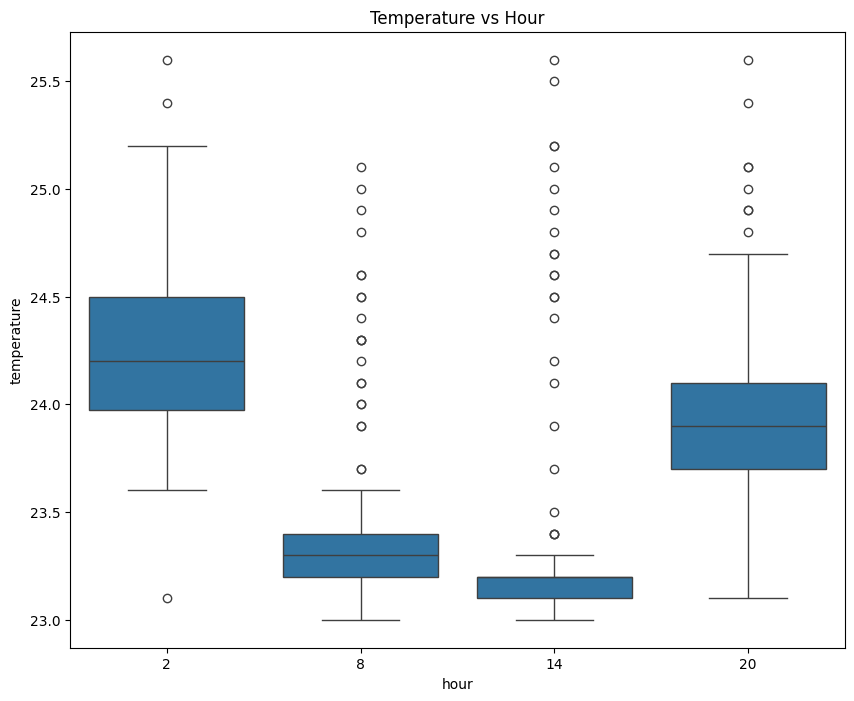

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_temperature, x='hour', y='Temperature')
ax.set_title('Temperature vs Hour')
ax.set_ylabel('temperature')
plt.show()

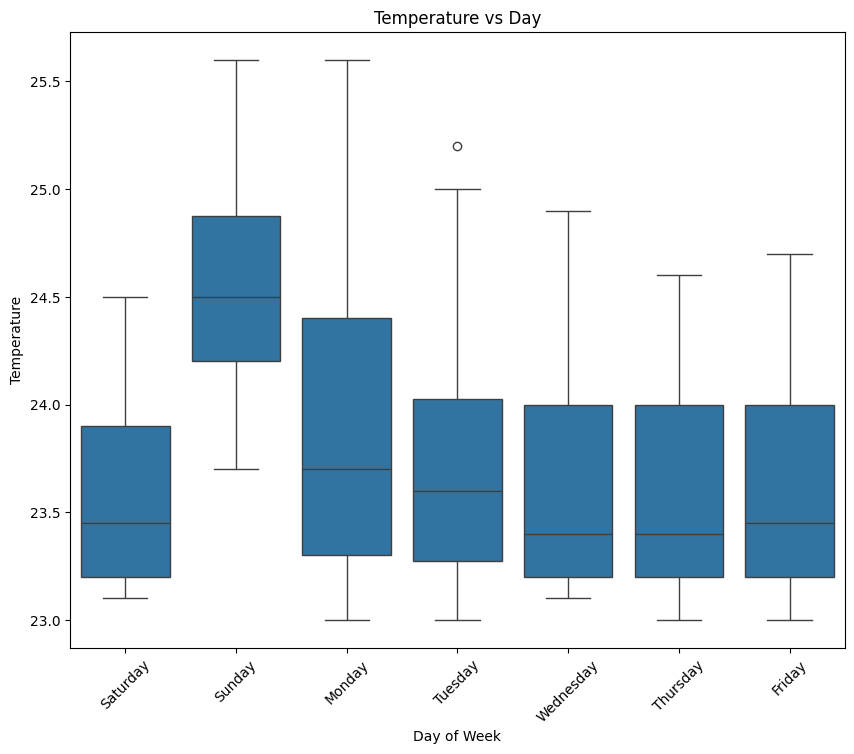

In [9]:
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

df_temperature['dayofweek_name'] = df_temperature['dayofweek'].map(day_names)

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_temperature, x='dayofweek_name', y='Temperature')
ax.set_title('Temperature vs Day')
ax.set_xlabel('Day of Week') 
ax.set_ylabel('Temperature')
plt.xticks(rotation=45)
plt.show()


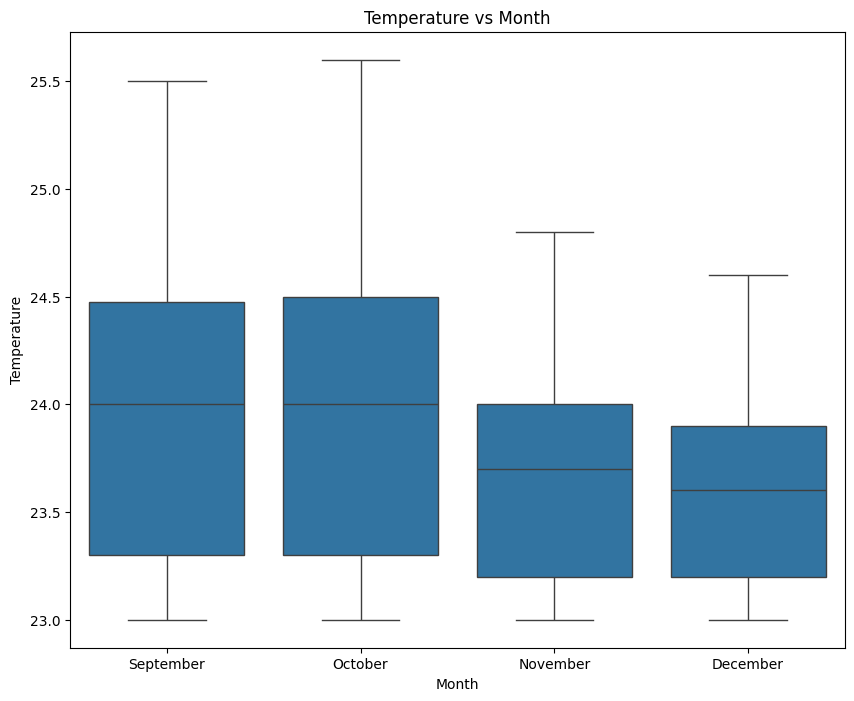

In [10]:
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_temperature, x='month', y='Temperature')

ax.set_title('Temperature vs Month')
ax.set_ylabel('Temperature')
ax.set_xlabel('Month')

unique_months = sorted(df_temperature['month'].unique())

ax.set_xticks(range(len(unique_months)))

ax.set_xticklabels([month_names[month] for month in unique_months])

plt.show()


# Create our Model

In [11]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'dayofyear', 'quarter', 'month', 'year']

TARGET = 'Temperature'
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

print(X_train)
print(y_train)

                     hour  dayofweek  dayofyear  quarter  month  year
dateTime                                                             
2023-09-09 14:00:00    14          5        252        3      9  2023
2023-09-09 20:00:00    20          5        252        3      9  2023
2023-09-10 02:00:00     2          6        253        3      9  2023
2023-09-10 08:00:00     8          6        253        3      9  2023
2023-09-10 14:00:00    14          6        253        3      9  2023
...                   ...        ...        ...      ...    ...   ...
2023-12-08 02:00:00     2          4        342        4     12  2023
2023-12-08 08:00:00     8          4        342        4     12  2023
2023-12-08 14:00:00    14          4        342        4     12  2023
2023-12-08 20:00:00    20          4        342        4     12  2023
2023-12-09 02:00:00     2          5        343        4     12  2023

[360 rows x 6 columns]
dateTime
2023-09-09 14:00:00    23.1
2023-09-09 20:00:00    23.9
2

# Train Model

In [12]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:23.09873	validation_1-rmse:22.85714
[100]	validation_0-rmse:8.49867	validation_1-rmse:8.24947
[200]	validation_0-rmse:3.15746	validation_1-rmse:2.88679
[300]	validation_0-rmse:1.20050	validation_1-rmse:0.98485
[400]	validation_0-rmse:0.49367	validation_1-rmse:0.39762
[500]	validation_0-rmse:0.25040	validation_1-rmse:0.20273
[600]	validation_0-rmse:0.17539	validation_1-rmse:0.14956
[700]	validation_0-rmse:0.15369	validation_1-rmse:0.13979


/common/home/projectgrps/IS460/IS460G6/jupyterlab-venv-py311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:21:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[800]	validation_0-rmse:0.14325	validation_1-rmse:0.13833
[825]	validation_0-rmse:0.14103	validation_1-rmse:0.13855


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Feature Importance

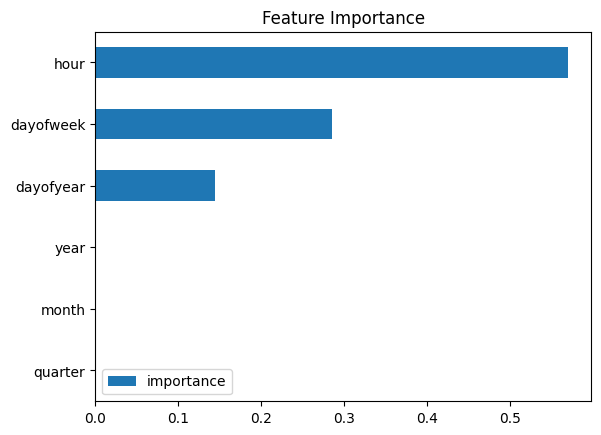

In [13]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test Dataset

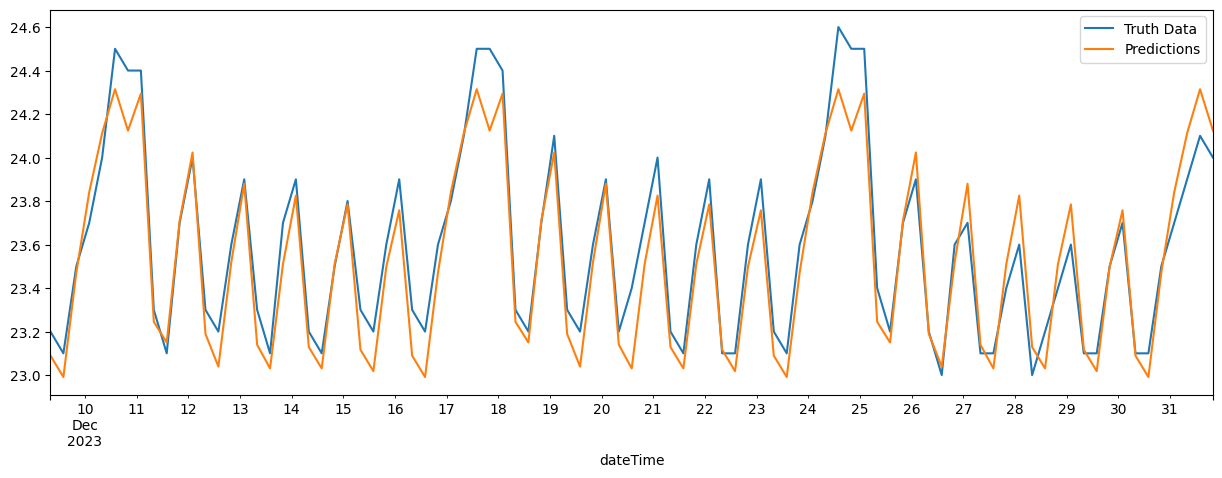

In [14]:
test['prediction'] = reg.predict(X_test)
test['Temperature'].plot(figsize=(15, 5))
test['prediction'].plot(figsize=(15, 5))
plt.legend(['Truth Data', 'Predictions'])
plt.show()

# Score (RMSE)

In [15]:
score = np.sqrt(mean_squared_error(test['Temperature'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.14


# Calculate Error
- Look at the worst and best predicted days

In [16]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-12-24    0.178680
2023-12-10    0.178680
2023-12-31    0.172805
2023-12-16    0.172751
2023-12-20    0.159919
2023-12-28    0.158526
2023-12-17    0.153680
2023-12-23    0.122751
2023-12-15    0.120712
2023-12-13    0.109919
Name: error, dtype: float64

# Predicting the Future

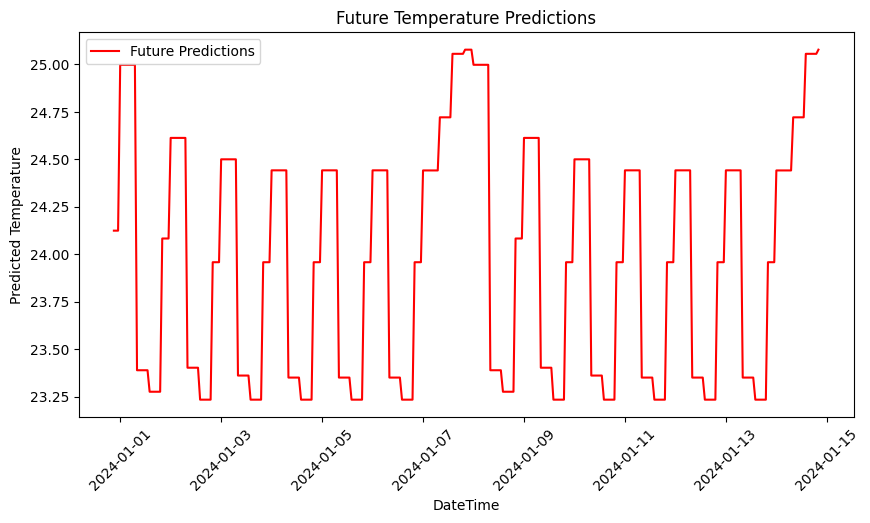

In [17]:
# Step 1: Generate Future Time Frame
# Define a start date for the future predictions and the number of periods/hours you want to predict
future_start_date = df_temperature.index.max() + pd.Timedelta(hours=1)
num_days = 14 # ADJUST THIS
num_hours = 0 # ADJUST THIS
num_future_periods = (num_days * 24) + num_hours  # For example, predicting the next 24 hours

# Generate future datetime index
future_dates = pd.date_range(start=future_start_date, periods=num_future_periods, freq='h')

# Create a DataFrame for the future time frame
future_df = pd.DataFrame(index=future_dates, columns=FEATURES)
future_df.index.name = 'dateTime'

# Step 2: Create Features for Future Time Frame
# Use the create_features function to generate features for the future_df
future_df = create_features(future_df)

# Step 3: Predict Future Values
# Make sure to select only the columns used as features
future_df['prediction'] = reg.predict(future_df[FEATURES])

# Visualize the future predictions
plt.figure(figsize=(10, 5))
plt.plot(future_df.index, future_df['prediction'], label='Future Predictions', color='red')
plt.title('Future Temperature Predictions')
plt.xlabel('DateTime')
plt.ylabel('Predicted Temperature')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Note: This is a simplified approach and assumes the existence of features that can be generated 
# without having actual future values (e.g., time-based features). For features dependent on unknown future 
# conditions or values, you'd need to estimate or model those features differently.


# Saving Model

In [18]:
# Save model
reg.save_model('model_temperature_vendor.json')

In [19]:
!ls -lh

total 15M
-rw-rw-r--. 1 IS460G6 IS460G6  15K Mar 10 17:34 archieve.ipynb
-rw-rw-r--. 1 IS460G6 IS460G6  18K Mar  4 17:43 Draft1.ipynb
-rw-rw-r--. 1 IS460G6 IS460G6  468 Mar 15 17:16 future_temperature_predictions.csv
-rw-rw-r--. 1 IS460G6 IS460G6 424K Mar  4 17:41 lstm_model.h5
-rw-rw-r--. 1 IS460G6 IS460G6 2.3K Mar  4 17:18 lstm_model.py
-rw-rw-r--. 1 IS460G6 IS460G6  740 Mar  4 17:18 lstm_predict.py
-rw-rw-r--. 1 IS460G6 IS460G6 428K Mar 11 10:47 model_co2.json
-rw-rw-r--. 1 IS460G6 IS460G6 489K Mar 11 11:50 model_co2_vendor.json
-rw-rw-r--. 1 IS460G6 IS460G6 300K Mar 15 20:21 model_CO2_vendor.json
-rw-rw-r--. 1 IS460G6 IS460G6 246K Mar 11 10:47 model_humidity.json
-rw-rw-r--. 1 IS460G6 IS460G6 853K Mar 15 20:21 model_humidity_vendor.json
-rw-rw-r--. 1 IS460G6 IS460G6 246K Mar 10 17:41 model.json
-rw-rw-r--. 1 IS460G6 IS460G6 346K Mar 11 10:47 model_temperature.json
-rw-rw-r--. 1 IS460G6 IS460G6 724K Mar 15 20:21 model_temperature_vendor.json
-rw-rw-r--. 1 IS460G6 IS460G6 3.9M Mar 10

# Using Model from Saved Model

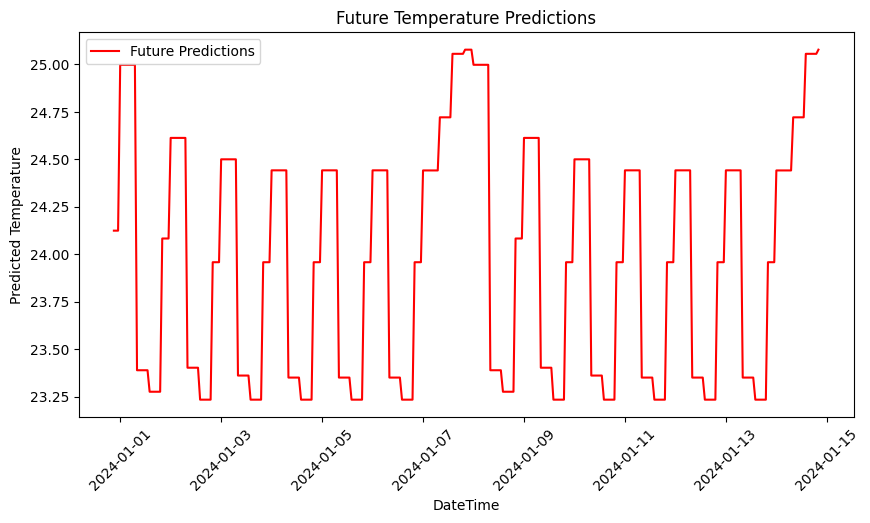

In [20]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model_temperature_vendor.json')

future_start_date = df_temperature.index.max() + pd.Timedelta(hours=1)
num_days = 14 # ADJUST THIS
num_hours = 0 # ADJUST THIS
num_future_periods = (num_days * 24) + num_hours  # For example, predicting the next 24 hours

# Generate future datetime index
future_dates = pd.date_range(start=future_start_date, periods=num_future_periods, freq='h')

# Create a DataFrame for the future time frame
future_df = pd.DataFrame(index=future_dates, columns=FEATURES)
future_df.index.name = 'dateTime'

# Step 2: Create Features for Future Time Frame
# Use the create_features function to generate features for the future_df
future_df = create_features(future_df)

# Step 3: Predict Future Values
# Make sure to select only the columns used as features
future_df['prediction'] = reg_new.predict(future_df[FEATURES])

# Visualize the future predictions
plt.figure(figsize=(10, 5))
plt.plot(future_df.index, future_df['prediction'], label='Future Predictions', color='red')
plt.title('Future Temperature Predictions')
plt.xlabel('DateTime')
plt.ylabel('Predicted Temperature')
plt.xticks(rotation=45)
plt.legend()
plt.show()